In [59]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

%matplotlib inline


from tensorflow import keras, config
from keras import layers

physical_devices = config.list_physical_devices('GPU') 
try:
    config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

In [60]:
def create_dataframe_from_xml(xml_folder, root_element):
    df = pd.DataFrame() 

    for filename in os.listdir(xml_folder):
        if filename.endswith(".xml"):
            xml_file = os.path.join(xml_folder, filename)

            try:
                # Analizza il file XML
                tree = ET.parse(xml_file)
                root = tree.getroot()

                # Inizializza una lista per memorizzare i dati
                data = []

                # Itera sugli elementi desiderati nel file XML
                for element in root.findall(f'.//{root_element}'):
                    data_dict = {}
                    for child in element:
                        data_dict[child.tag] = child.text
                    data.append(data_dict)

                temp_df = pd.DataFrame(data)
                df = pd.concat([df, temp_df], ignore_index=True)
            
            except ET.ParseError as e:
                print(f"Errore durante il parsing del file {xml_file}: {e}")

    return df


In [61]:
df = create_dataframe_from_xml("data_prices_6months", 'Prezzi')
print('Price data created')

Price data created


In [62]:
df_summer = create_dataframe_from_xml("data_prices", 'Prezzi')
print('Price data created')

Price data created


In [63]:
def make_yearly_dataset(df, start_year, end_year):
    if start_year == end_year:
        return df[df.index.year == start_year]
    else:
        return df[(df.index.year >= start_year) & (df.index.year <= end_year)]

In [64]:
df_summer.head()

,Data,Mercato,Ora,PUN,NAT,CNOR,CSUD,NORD,SARD,SICI,...,XAUS,XFRA,MONT,CALA,COUP,XGRE,BRNN,FOGN,MFTV,PRGP
0,20200401,MGP,1,"24,478870","23,900000","22,260000","22,260000","22,260000","22,260000","54,840000",...,"22,260000","22,260000","22,260000",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20200401,MGP,2,"20,603840","21,590000","20,221100","20,221100","20,221100","20,221100","25,990000",...,"20,221100","20,221100","20,221100",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20200401,MGP,3,"19,670000","19,670000","19,670000","19,670000","19,670000","19,670000","19,670000",...,"19,670000","19,670000","19,670000",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20200401,MGP,4,"19,247970","19,100000","19,247970","19,247970","19,247970","19,247970","19,247970",...,"19,247970","19,247970","19,247970",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20200401,MGP,5,"19,305070","19,000000","19,305070","19,305070","19,305070","19,305070","19,305070",...,"19,305070","19,305070","19,305070",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
df['Data'] = pd.to_datetime(df['Data'])
df = df.drop(columns = 'Mercato')

In [66]:
df = df.loc[:, :'SUD']
numeric_columns = df.loc[:, 'PUN':'SUD']
# Sostituisci le virgole con punti e converte in numeri float
for col in numeric_columns.columns:
    df[col] = df[col].str.replace(',', '.').astype(float)

df['Ora'] = df['Ora'].astype(int)

In [67]:
def split_temporal_indices(df):
    # Estrai l'anno, il mese, il giorno della settimana e l'ora dalla colonna 'DataCompleta'
    # df['Mese'] = df['Data'].dt.month
    df['GiornoSettimana'] = df['Data'].dt.dayofweek
    # df['Weekend'] = df['GiornoSettimana'].apply(lambda x: 1 if x > 4 else 0)  # 5 e 6 rappresentano sabato e domenica
    # df['Ora'] = df['Data'].dt.hour


    return df

df = split_temporal_indices(df)


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5136 entries, 0 to 5135
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Data             5136 non-null   datetime64[ns]
 1   Ora              5136 non-null   int64         
 2   PUN              5136 non-null   float64       
 3   NAT              5136 non-null   float64       
 4   CALA             5136 non-null   float64       
 5   CNOR             5136 non-null   float64       
 6   CSUD             5136 non-null   float64       
 7   NORD             5136 non-null   float64       
 8   SARD             5136 non-null   float64       
 9   SICI             5136 non-null   float64       
 10  SUD              5136 non-null   float64       
 11  GiornoSettimana  5136 non-null   int32         
dtypes: datetime64[ns](1), float64(9), int32(1), int64(1)
memory usage: 461.6 KB


In [69]:
# df.reset_index(inplace=True)

df['Time_data'] = df['Data'].apply(lambda t: pd.Timestamp(t).normalize().tz_localize('CET')) + \
                    df['Ora'].apply(lambda h: pd.Timedelta(hours=h))

df.set_index('Time_data', inplace=True)

In [70]:
df.head()

,Data,Ora,PUN,NAT,CALA,CNOR,CSUD,NORD,SARD,SICI,SUD,GiornoSettimana
Time_data,,,,,,,,,,,,
2023-11-16 01:00:00+01:00,2023-11-16,1,108.60,108.60,108.60,108.60,108.60,108.60,108.60,108.60,108.60,3
2023-11-16 02:00:00+01:00,2023-11-16,2,103.91,103.91,103.91,103.91,103.91,103.91,103.91,103.91,103.91,3
2023-11-16 03:00:00+01:00,2023-11-16,3,103.91,103.91,103.91,103.91,103.91,103.91,103.91,103.91,103.91,3
2023-11-16 04:00:00+01:00,2023-11-16,4,103.91,103.91,103.91,103.91,103.91,103.91,103.91,103.91,103.91,3
2023-11-16 05:00:00+01:00,2023-11-16,5,107.67,107.67,107.67,107.67,107.67,107.67,107.67,107.67,107.67,3


In [71]:
# df = df.set_index('Data', inplace=False)

In [72]:
df = df.round(2)
df = df.sort_index()

In [73]:
df.index

DatetimeIndex(['2023-09-01 01:00:00+02:00', '2023-09-01 02:00:00+02:00',
               '2023-09-01 03:00:00+02:00', '2023-09-01 04:00:00+02:00',
               '2023-09-01 05:00:00+02:00', '2023-09-01 06:00:00+02:00',
               '2023-09-01 07:00:00+02:00', '2023-09-01 08:00:00+02:00',
               '2023-09-01 09:00:00+02:00', '2023-09-01 10:00:00+02:00',
               ...
               '2024-04-01 15:00:00+02:00', '2024-04-01 16:00:00+02:00',
               '2024-04-01 17:00:00+02:00', '2024-04-01 18:00:00+02:00',
               '2024-04-01 19:00:00+02:00', '2024-04-01 20:00:00+02:00',
               '2024-04-01 21:00:00+02:00', '2024-04-01 22:00:00+02:00',
               '2024-04-01 23:00:00+02:00', '2024-04-02 00:00:00+02:00'],
              dtype='datetime64[ns, CET]', name='Time_data', length=5136, freq=None)

In [74]:
df.head(26)

,Data,Ora,PUN,NAT,CALA,CNOR,CSUD,NORD,SARD,SICI,SUD,GiornoSettimana
Time_data,,,,,,,,,,,,
2023-09-01 01:00:00+02:00,2023-09-01,1,110.27,110.21,110.34,110.34,110.34,110.21,110.34,110.34,110.34,4
2023-09-01 02:00:00+02:00,2023-09-01,2,109.57,109.57,109.57,109.57,109.57,109.57,109.57,109.57,109.57,4
2023-09-01 03:00:00+02:00,2023-09-01,3,109.51,109.51,109.51,109.51,109.51,109.51,109.51,109.51,109.51,4
2023-09-01 04:00:00+02:00,2023-09-01,4,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,4
2023-09-01 05:00:00+02:00,2023-09-01,5,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,4
2023-09-01 06:00:00+02:00,2023-09-01,6,103.64,103.64,103.64,103.64,103.64,103.64,103.64,103.64,103.64,4
2023-09-01 07:00:00+02:00,2023-09-01,7,112.05,112.00,112.05,112.05,112.05,112.05,112.05,112.05,112.05,4
2023-09-01 08:00:00+02:00,2023-09-01,8,128.85,128.85,128.85,128.85,128.85,128.85,128.85,128.85,128.85,4
2023-09-01 09:00:00+02:00,2023-09-01,9,136.00,136.00,136.00,136.00,136.00,136.00,136.00,136.00,136.00,4


In [75]:
# df = df.drop(df.index[-1]) # droppo l'ultima riga che c'è solo un valore di aprile

In [76]:
df = df.reindex(columns=[col for col in df.columns if col != 'Ora'] + ['Ora'])

In [77]:
df.head()

,Data,PUN,NAT,CALA,CNOR,CSUD,NORD,SARD,SICI,SUD,GiornoSettimana,Ora
Time_data,,,,,,,,,,,,
2023-09-01 01:00:00+02:00,2023-09-01,110.27,110.21,110.34,110.34,110.34,110.21,110.34,110.34,110.34,4,1
2023-09-01 02:00:00+02:00,2023-09-01,109.57,109.57,109.57,109.57,109.57,109.57,109.57,109.57,109.57,4,2
2023-09-01 03:00:00+02:00,2023-09-01,109.51,109.51,109.51,109.51,109.51,109.51,109.51,109.51,109.51,4,3
2023-09-01 04:00:00+02:00,2023-09-01,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,4,4
2023-09-01 05:00:00+02:00,2023-09-01,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,4,5


In [78]:
df.drop(columns=['NAT'], inplace=True)

In [79]:
df.drop(columns=['Data'], inplace=True)

Preprocessing per aggiungere una features che indica se è vacanza o meno

In [80]:
# from datetime import date
# from workalendar.europe import Italy

# years = list(range(2023, 2024))  # 2018 incluso, 2024 escluso
# holiday_dates = []

# for year in years:
#     holidays_year = Italy().holidays(year)
#     holiday_dates.extend([date for date, _ in holidays_year])

# holiday_dates_str = [date.strftime('%Y-%m-%d') for date in holiday_dates]

# # crea un indice date time index
# date_range = pd.date_range(start="2023-10-01", end="2024-04-01", freq='H')


# df_holiday = pd.DataFrame(index=date_range)

# # Add a column 'is_holiday' and set values based on holiday_dates_str
# df_holiday['is_holiday'] = df_holiday.index.strftime('%Y-%m-%d').isin(holiday_dates_str).astype(int)

# # Applico la stessa timezone a df_holiday
# df_holiday.index = df_holiday.index.tz_localize(df.index.tz)

# df = pd.merge(df, df_holiday, left_index=True, right_index=True, how='left')

# df.dropna(inplace=True)

# df['is_holiday'] = df['is_holiday'].astype(int)

# df['holiday'] = df['is_holiday'] | df['Weekend'] # operatore come l' OR 

# df.drop(columns=['Weekend', 'is_holiday'], inplace=True)

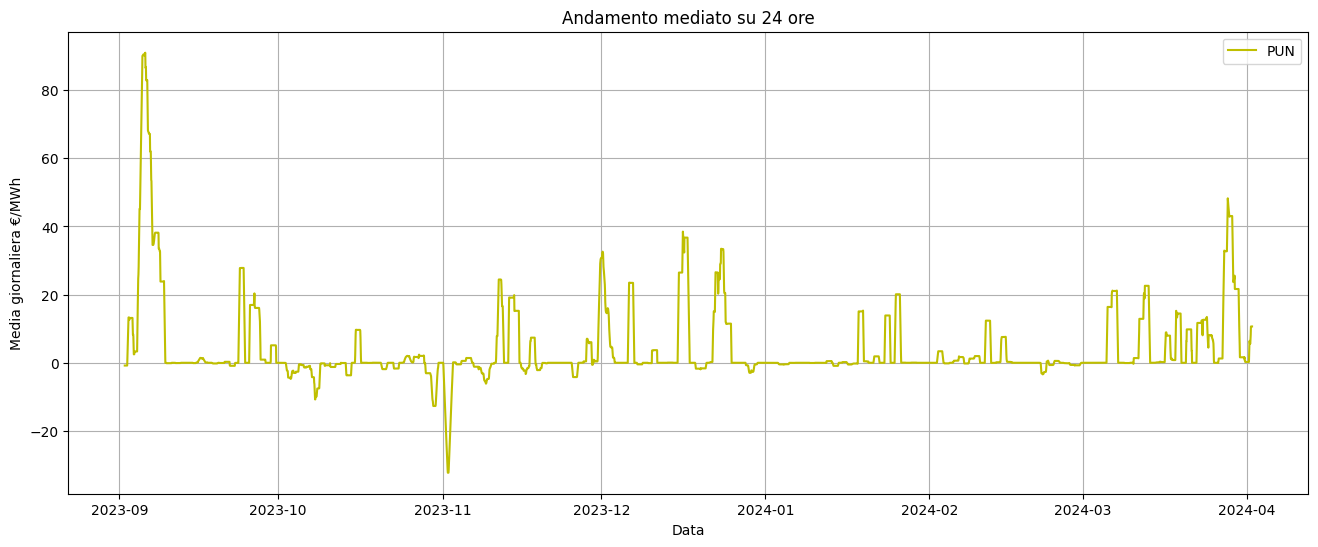

In [81]:
# Plot dell'andamento medio mediato su 24*7 ore
plt.figure(figsize=(16, 6))
plt.plot(df.index, (df['PUN'] - df['SARD']).rolling(24).mean(), linestyle='solid', color='y', linewidth=1.5, label='PUN')
# plt.plot(df.index, df['NORD'].rolling(24).mean(), linestyle='solid', color='r', linewidth=1, label='NORD')
# plt.plot(df.index, df['SICI'].rolling(24).mean(), linestyle='solid', color='b', linewidth=1, label='SICI')
plt.title('Andamento mediato su 24 ore')
plt.xlabel('Data')
plt.ylabel('Media giornaliera €/MWh')
plt.legend()
plt.grid(True)
plt.show()

In [82]:
zone_data = df.drop(columns=['GiornoSettimana', 'Ora']) # eventualmente aggiungere holiday

zone_means = zone_data.mean() # media di ogni prezzo zonale

pun_mean = zone_means['PUN']
percentage_diff = ((zone_means - pun_mean) / pun_mean) * 100
sorted_percentage_diff = percentage_diff.sort_values(ascending=False)

print("Classifica della media dei prezzi zonali rispetto al PUN:")
for zone, diff in sorted_percentage_diff.items():
    print(f"{zone}: {diff:.2f}%")

Classifica della media dei prezzi zonali rispetto al PUN:
CNOR: 0.93%
NORD: 0.17%
CSUD: 0.05%
PUN: 0.00%
SICI: -0.60%
SUD: -0.99%
CALA: -1.08%
SARD: -3.71%


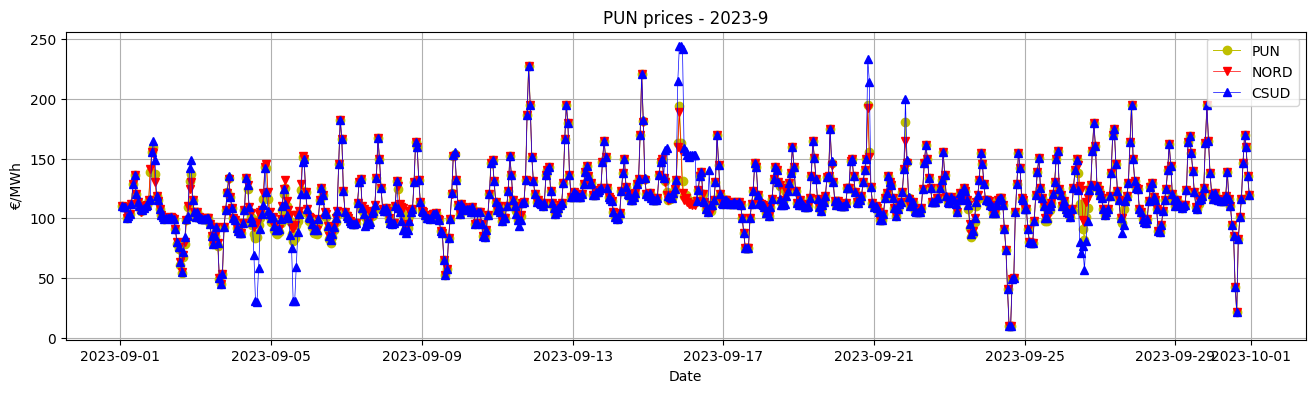

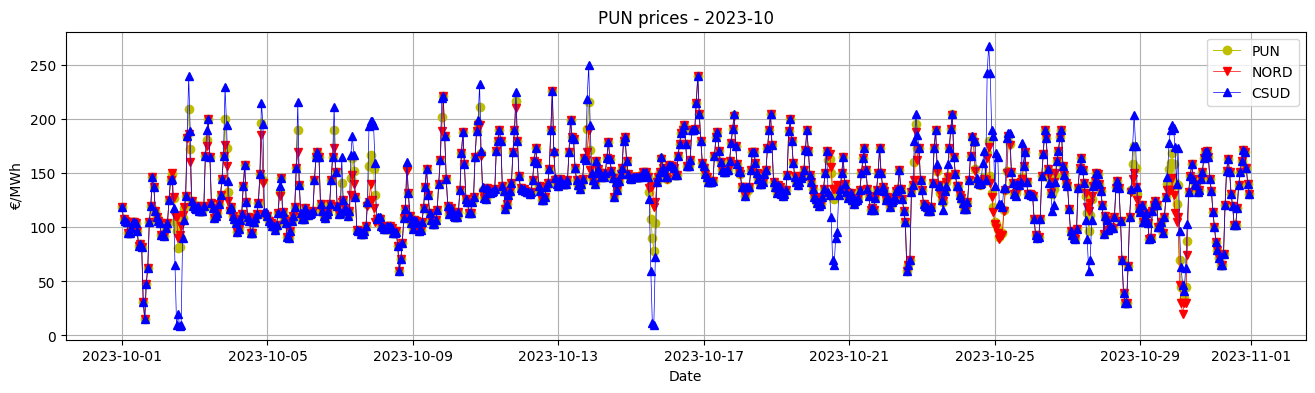

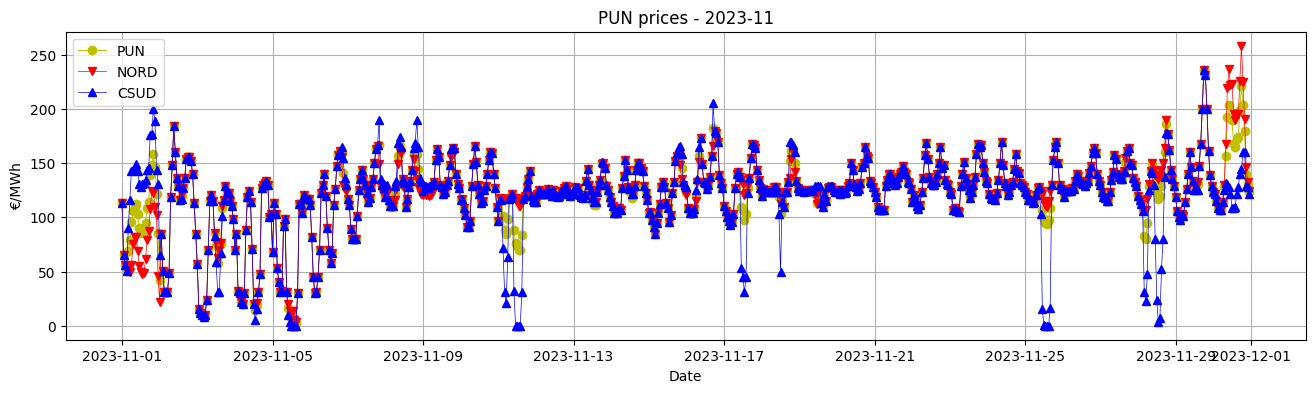

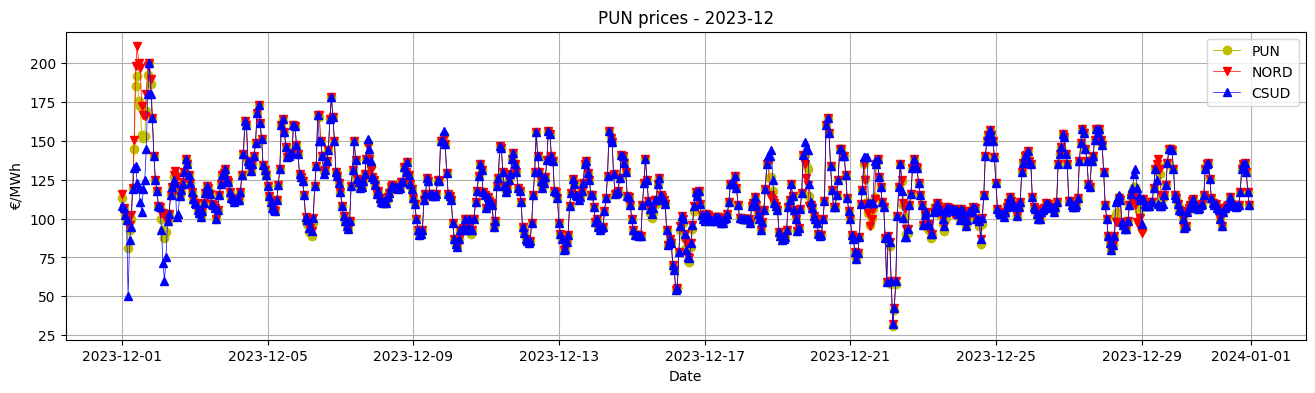

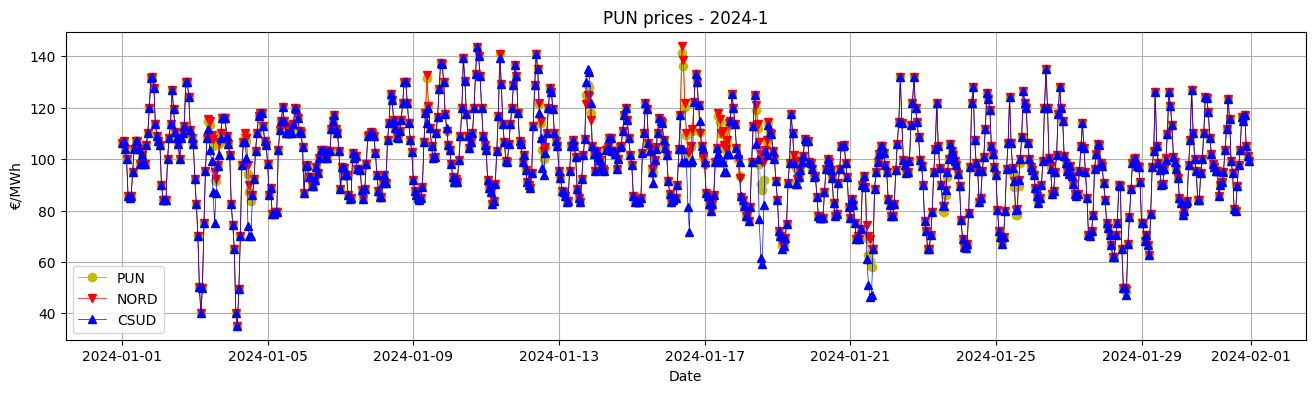

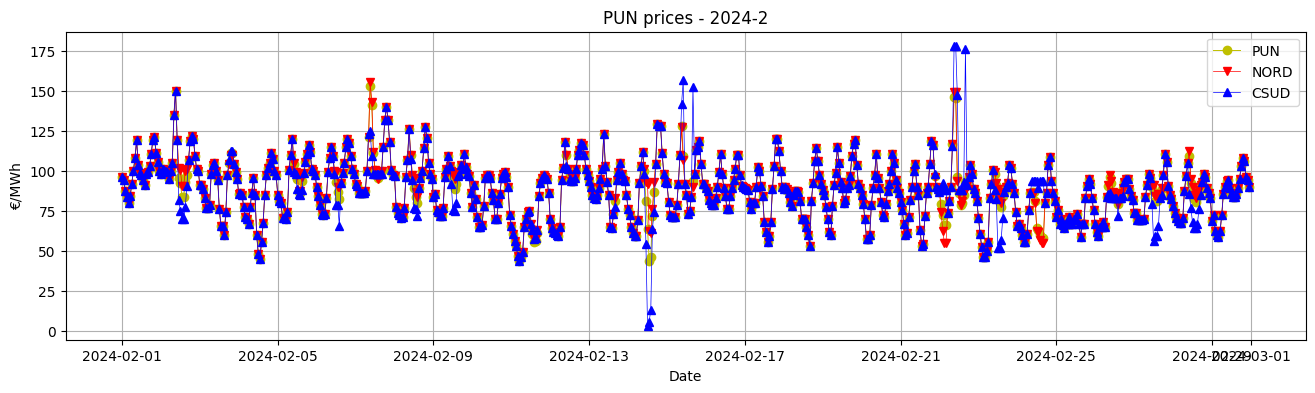

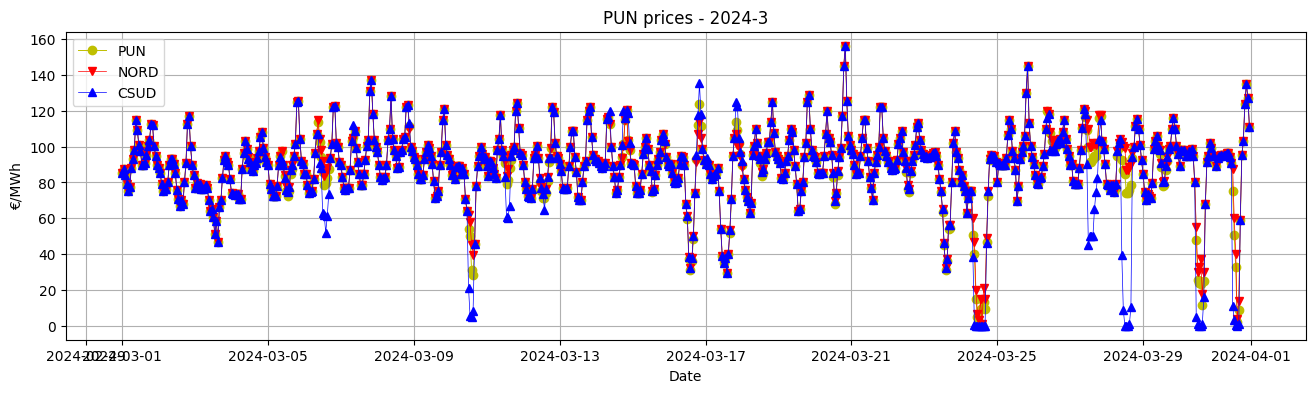

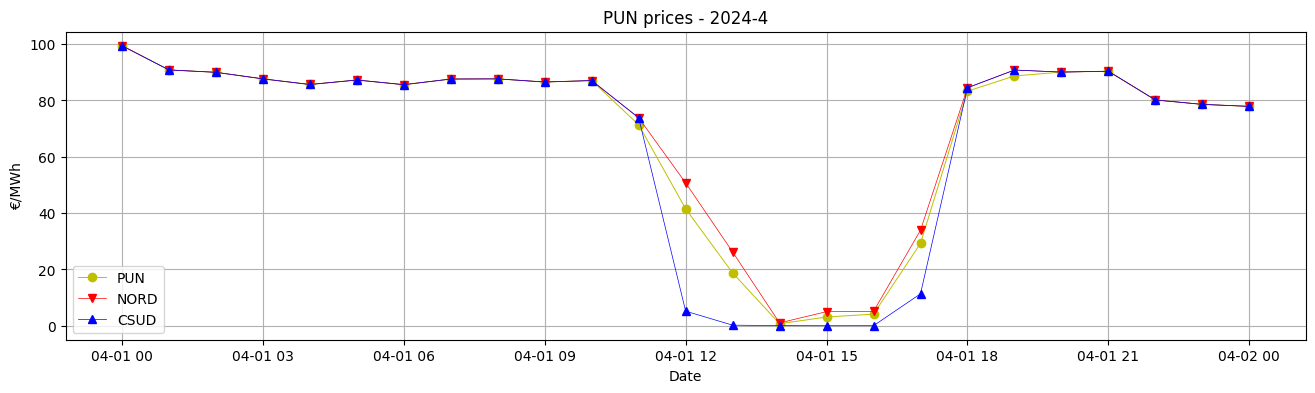

In [83]:
monthly_data = df.groupby([df.index.year, df.index.month])

for (year, month), data in monthly_data:
    plt.figure(figsize=(16, 4))
    plt.plot(data.index, data['PUN'], marker='o', linestyle='-', color='y', linewidth=0.7, label='PUN')
    plt.plot(data.index, data['NORD'], marker='v', linestyle='-', color='r', linewidth=0.5, label='NORD')
    plt.plot(data.index, data['SICI'], marker='^', linestyle='-', color='b', linewidth=0.5, label='CSUD')
    plt.title(f'PUN prices - {year}-{month}')
    plt.xlabel('Date')
    plt.ylabel('€/MWh')
    plt.legend()
    plt.grid(True)
    plt.show()

## Market splitting

In [84]:
df.head(15)

,PUN,CALA,CNOR,CSUD,NORD,SARD,SICI,SUD,GiornoSettimana,Ora
Time_data,,,,,,,,,,
2023-09-01 01:00:00+02:00,110.27,110.34,110.34,110.34,110.21,110.34,110.34,110.34,4,1
2023-09-01 02:00:00+02:00,109.57,109.57,109.57,109.57,109.57,109.57,109.57,109.57,4,2
2023-09-01 03:00:00+02:00,109.51,109.51,109.51,109.51,109.51,109.51,109.51,109.51,4,3
2023-09-01 04:00:00+02:00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,4,4
2023-09-01 05:00:00+02:00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,4,5
2023-09-01 06:00:00+02:00,103.64,103.64,103.64,103.64,103.64,103.64,103.64,103.64,4,6
2023-09-01 07:00:00+02:00,112.05,112.05,112.05,112.05,112.05,112.05,112.05,112.05,4,7
2023-09-01 08:00:00+02:00,128.85,128.85,128.85,128.85,128.85,128.85,128.85,128.85,4,8
2023-09-01 09:00:00+02:00,136.00,136.00,136.00,136.00,136.00,136.00,136.00,136.00,4,9


In [85]:
def splitting_count(df, zone):
    # Crea un contatore per registrare quante volte le altre zone sono andate in coupling con la zona specificata
    coupling_counter = {col: 0 for col in df.columns if col not in ['GiornoSettimana', 'Ora', zone]}
    
    for _, row in df.iterrows():
        # prezzo zona scelta
        zone_value = row[zone]
        # prezzo delle altre zone
        other_zones_values = row.drop(['GiornoSettimana', 'Ora', zone])
        
        # Conta quante altre zone sono in coupling 
        other_zones_with_same_value = (other_zones_values == zone_value).sum()
        
        # se in coupling, incrementa il contatore per quella zona
        if other_zones_with_same_value >= 1:
            for column, value in other_zones_values.items():
                if value == zone_value:
                    coupling_counter[column] += 1
    
    return coupling_counter


In [86]:
# Utilizzo della funzione per contare il numero di volte in cui due o più zone hanno lo stesso valore per la variabile 'PUN'
conteggio_valori_uguali = splitting_count(df, 'PUN')
print("Conteggio dei valori uguali per ogni zona:")
print(conteggio_valori_uguali)


Conteggio dei valori uguali per ogni zona:
{'CALA': 4204, 'CNOR': 4204, 'CSUD': 4205, 'NORD': 4204, 'SARD': 4204, 'SICI': 4203, 'SUD': 4204}


Quanto più frequente è la differenza di prezzo tra le Zone a ridosso delle sezioni di separazione, oltre che rispetto al PUN (prezzo unico nazionale), tanto più consistenti sono le congestioni di rete che impediscono lo sfruttamento delle risorse di produzione maggiormente competitive. Si conferma la tendenza del prezzo al Sud che si attesta a valori inferiori rispetto al Nord sempre per effetto della nuova configurazione zonale e dell’ingresso di nuova capacità produttiva competitiva [...] Un indice significativo per valutare lo squilibrio nell’allocazione delle risorse tra le zone di mercato e/o di inefficienza strutturale della rete è costituito dalla frequenza con cui si è verificata la saturazione del margine di scambio tra le zone di mercato inesito al Mercato del Giorno Prima. 

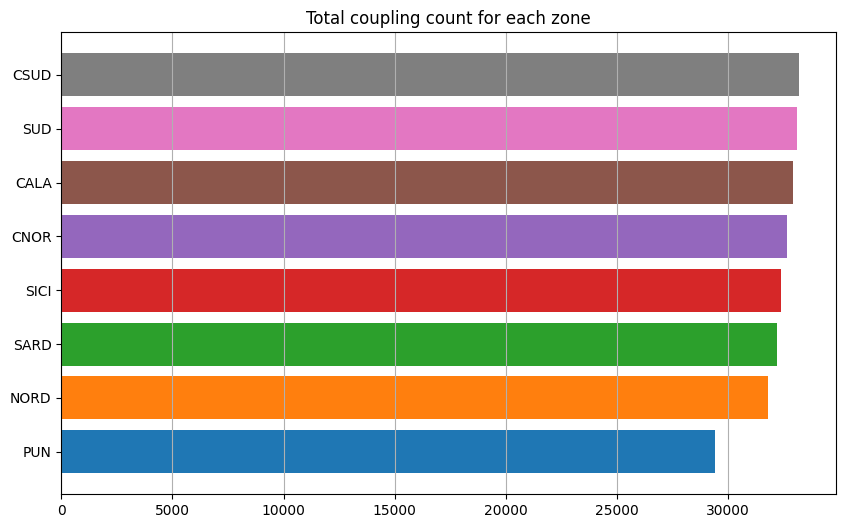

In [87]:
temporal_cols = ['GiornoSettimana', 'Ora']

counts = {}
for zone in df.columns:
    if zone not in temporal_cols:
        counts[zone] = splitting_count(df, zone)

sorted_counts = dict(sorted(counts.items(), key=lambda x: sum(x[1].values()), reverse=False))

plt.figure(figsize=(10, 6))
for zone, count in sorted_counts.items():
    plt.barh(zone, sum(count.values()))

plt.title('Total coupling count for each zone')
plt.grid(axis='x')
plt.show()

In [88]:
total_hour = len(df)

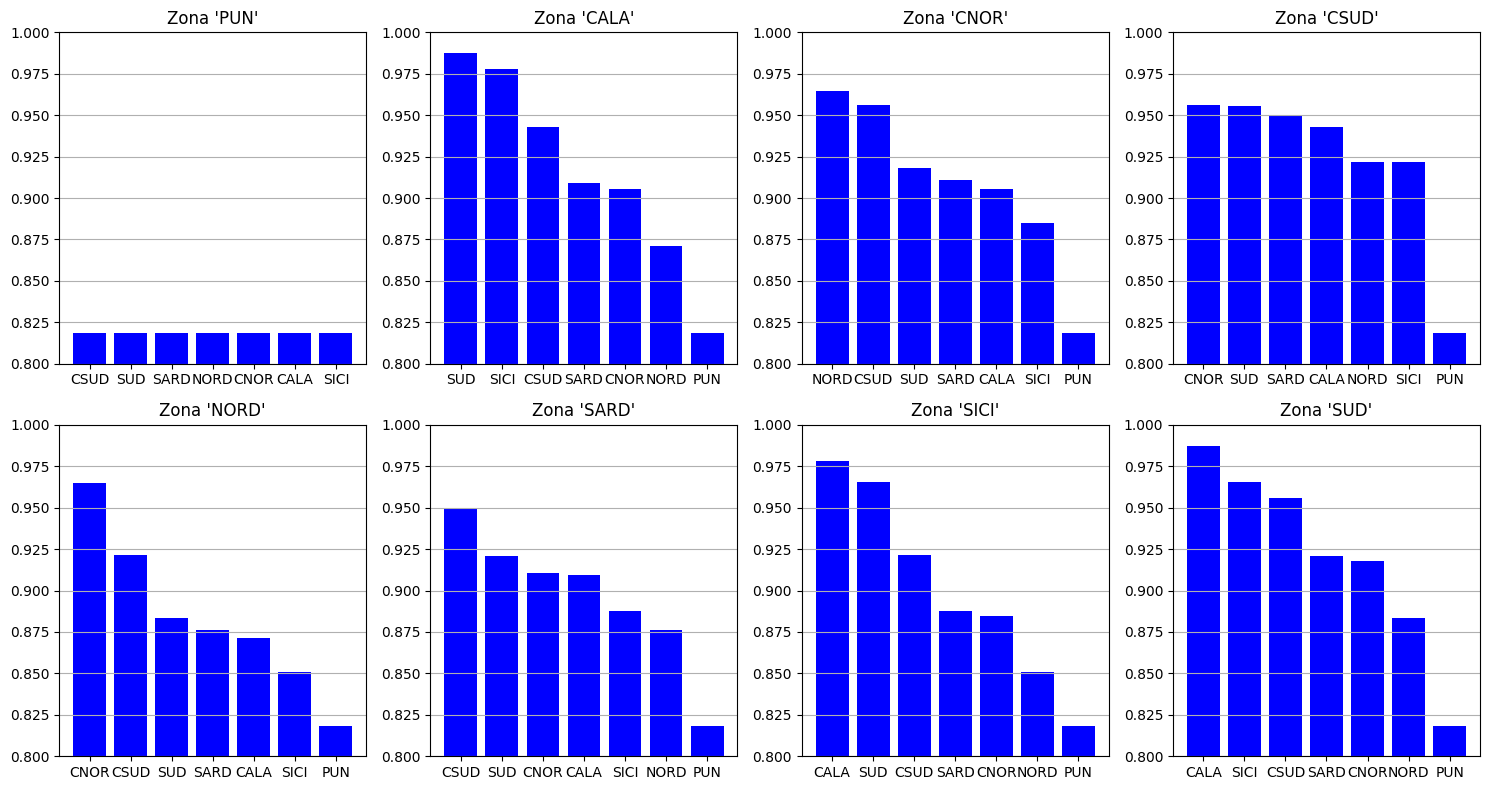

In [89]:
# Lista delle colonne da escludere dal conteggio
exclude_cols = ['GiornoSettimana', 'Ora']

fig, axs = plt.subplots(2, 4, figsize=(15, 8))

for i, zone in enumerate(df.columns):
    if zone not in exclude_cols:
        zone_counter = splitting_count(df, zone)
        zone_counter = {k: v/total_hour for k,v in zone_counter.items()}
        # Ordina il dizionario in ordine decrescente rispetto al conteggio
        zone_counter_sorted = dict(sorted(zone_counter.items(), key=lambda item: item[1], reverse=False))
        row = i // 4
        col = i % 4
        axs[row, col].bar(list(zone_counter_sorted.keys()), list(zone_counter_sorted.values()), color='b')
        axs[row, col].set_title(f"Zona '{zone}'")
        axs[row, col].grid(axis='y')  # Griglia solo sull'asse y
        axs[row, col].set_ylim([0.8,1])
        axs[row, col].invert_xaxis()  # Inverti l'asse x per avere il conteggio maggiore a sinistra

plt.tight_layout()
plt.show()

In [90]:
def splitting_count_with_time(df, zone):
    # Crea un contatore per registrare quante volte le altre zone sono andate in coupling con la zona specificata
    coupling_counter = {col: 0 for col in df.columns if col not in ['GiornoSettimana', 'Ora', zone]}
    
    weekday_counter = {i: 0 for i in range(7)} # 7 escluso, vanno da 0 a 6
    hour_counter = {i: 0 for i in range(25)}
    
    for _, row in df.iterrows():
        # prezzo zona scelta
        zone_value = row[zone]
        # prezzo delle altre zone
        other_zones_values = row.drop(['GiornoSettimana', 'Ora', zone])
        
        # Conta quante altre zone sono in coupling 
        other_zones_with_same_value = (other_zones_values == zone_value).sum()
        
        # se in coupling, incrementa il contatore per quella zona
        if other_zones_with_same_value >= 1:
            for column, value in other_zones_values.items():
                if value == zone_value:
                    coupling_counter[column] += 1
                    # Incrementa il contatore per GiornoSettimana
                    weekday_counter[row['GiornoSettimana']] += 1
                    # Incrementa il contatore per Ora
                    hour_counter[row['Ora']] += 1
    
    
    total_sum = sum(weekday_counter.values())
    weekday_counter = {key: round((value / total_sum) * 100, 2) for key, value in weekday_counter.items()}

    total_sum = sum(hour_counter.values())
    hour_counter = {key: round((value / total_sum) * 100, 2) for key, value in hour_counter.items()}
    
    return coupling_counter, weekday_counter, hour_counter

{'CALA': 4204, 'CNOR': 4204, 'CSUD': 4205, 'NORD': 4204, 'SARD': 4204, 'SICI': 4203, 'SUD': 4204}


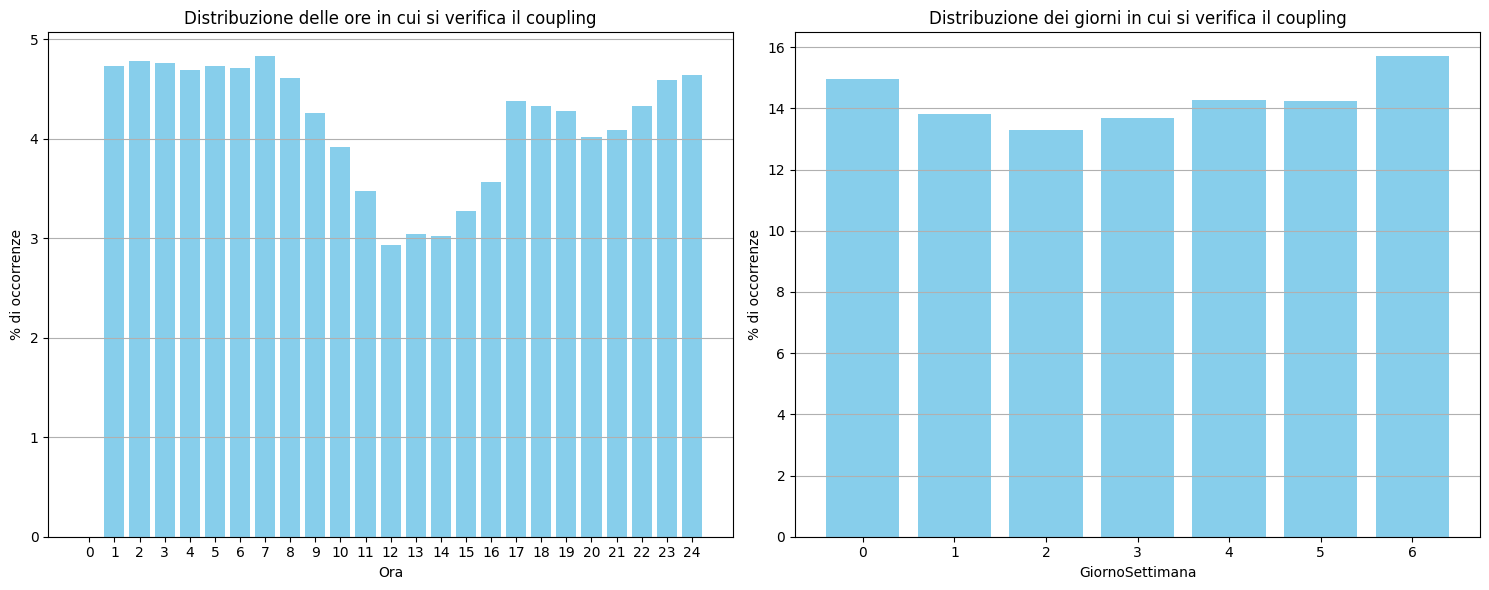

In [91]:
coupling_pun, weekday_pun, hour_pun = splitting_count_with_time(df, 'PUN')

print(coupling_pun)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# istogramma ore
axs[0].bar(hour_pun.keys(), hour_pun.values(), color='skyblue')
axs[0].set_title('Distribuzione delle ore in cui si verifica il coupling')
axs[0].set_xlabel('Ora')
axs[0].set_ylabel('% di occorrenze')
axs[0].set_xticks(range(0, 25))
axs[0].grid(axis='y')

# Istogramma settimana
axs[1].bar(weekday_pun.keys(), weekday_pun.values(), color='skyblue')
axs[1].set_title('Distribuzione dei giorni in cui si verifica il coupling')
axs[1].set_xlabel('GiornoSettimana')
axs[1].set_ylabel('% di occorrenze')
axs[1].set_xticks(range(0, 7))
axs[1].grid(axis='y')

plt.tight_layout()
plt.show()


### Test per verificare l'ipotesi i uniformità

In [92]:
def counter_for_test(df, zone):
    weekday_counter = {i: 0 for i in range(7)} # 7 escluso, vanno da 0 a 6
    hour_counter = {i: 0 for i in range(25)}
    
    for _, row in df.iterrows():
        # prezzo zona scelta
        zone_value = row[zone]
        # prezzo delle altre zone
        other_zones_values = row.drop(['GiornoSettimana', 'Ora', zone])
        
        # Conta quante altre zone sono in coupling 
        other_zones_with_same_value = (other_zones_values == zone_value).sum()
        
        # se in coupling, incrementa il contatore per quella zona
        if other_zones_with_same_value >= 1:
            for column, value in other_zones_values.items():
                if value == zone_value:
                    # Incrementa il contatore per GiornoSettimana
                    weekday_counter[row['GiornoSettimana']] += 1
                    # Incrementa il contatore per Ora
                    hour_counter[row['Ora']] += 1
    

    return weekday_counter, hour_counter

observed_weekdays, observed_hours = counter_for_test(df, 'PUN')

In [93]:
from scipy.stats import chi2_contingency

# Calcola la frequenza totale delle ore osservate
total_samples = sum(observed_weekdays.values())

# Calcola la frequenza attesa per ogni ora (ipotesi di uniformità)
expected_frequency = total_samples / len(observed_weekdays) 
expected_weekdays = [expected_frequency] * len(observed_weekdays)

# Trasforma le frequenze osservate e attese in liste
observed_weekdays_list = list(observed_weekdays.values())
expected_weekdays_list = expected_weekdays

In [94]:
# observed_weekdays_list = [x / 10 for x in observed_weekdays_list]

In [95]:
expected_weekdays

[4204.0, 4204.0, 4204.0, 4204.0, 4204.0, 4204.0, 4204.0]

In [96]:
# Applica il test del chi-quadro
chi2_hours, p_value_hours, dof, expected = chi2_contingency([observed_weekdays_list, expected_weekdays])

# Valuta il risultato del test
print("Test del Chi-quadro per l'istogramma dei giorni:")
print("Statistiche Chi-quadro:", chi2_hours)
print("Valore p:", p_value_hours)

Test del Chi-quadro per l'istogramma dei giorni:
Statistiche Chi-quadro: 40.688428969713236
Valore p: 3.335051238622381e-07


In [97]:
# Le ore palesemente non hanno distribuzione uniforme, infatti il p-value è infinitesimo

observed_hours = {1: 1393, 2: 1406, 3: 1400, 4: 1379, 5: 1393, 6: 1386, 7: 1421, 8: 1358, 9: 1253, 10: 1155, 11: 1023, 12: 861, 13: 896, 14: 889, 15: 966, 16: 1050, 17: 1288, 18: 1274, 19: 1260, 20: 1183, 21: 1204, 22: 1274, 23: 1351, 24: 1365}

# Calcola la frequenza totale delle ore osservate
total_samples = sum(observed_hours.values())

# Calcola la frequenza attesa per ogni ora (ipotesi di uniformità)
expected_frequency = total_samples / len(observed_hours)
expected_hours = [expected_frequency] * len(observed_hours)

# Trasforma le frequenze osservate e attese in liste
observed_hours_list = list(observed_hours.values())
expected_hours_list = expected_hours

# Applica il test del chi-quadro
chi2_hours, p_value_hours, dof, expected = chi2_contingency([observed_hours_list, expected_hours_list])

# Valuta il risultato del test
print("Test del Chi-quadro per l'istogramma delle ore:")
print("Statistiche Chi-quadro:", chi2_hours)
print("Valore p:", p_value_hours)

Test del Chi-quadro per l'istogramma delle ore:
Statistiche Chi-quadro: 337.41303189043185
Valore p: 1.1715946923207922e-57
